# Harris County Home Price Estimations


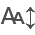

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from haversine import haversine
from sklearn.ensemble import GradientBoostingRegressor


from Load_to_DataFrame import load_data_frame

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=True)

In [2]:
df = load_data_frame()

In [3]:
# from math import sin, cos, sqrt, radians, atan2


# def haversine_distance(lat1, lon1, lat2, lon2):
#     """
#     Calculates the Haversine distance between two points on a sphere.
#     """
#     # R = 6371  # Earth radius in kilometers
#     R = 3956  # Eath radius in miles
#     dlat = radians(lat2 - lat1)
#     dlon = radians(lon2 - lon1)
#     a = (
#         sin(dlat / 2) ** 2
#         + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
#     )
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))
#     return R * c

# # Reference point coordinates
# ref_lat = 29.760100
# ref_lon = -95.370100

# # Add a new column with calculated distances
# df["distance"] = df.apply(
#     lambda row: haversine_distance(ref_lat, ref_lon, row["lat"], row["long"]),
#     axis=1,
# )

In [4]:
# Define the haversine function
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    R = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


# # Example DataFrame with latitude and longitude
# data = {
#     "latitude": [34.0522, 36.1699, 40.7128],  # Los Angeles, Las Vegas, New York
#     "longitude": [-118.2437, -115.1398, -74.0060]
# }
# df = pd.DataFrame(data)

# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(single_point[0], single_point[1], row["lat"], row["long"]),
    axis=1,
)

In [5]:
df["assessed_per_sqft"] = df["assessed_per_sqft"].replace([np.inf, -np.inf], np.nan)

In [6]:
show(df)

In [7]:
df["assessed_per_sqft"].describe()

count    1.120228e+06
mean     1.830192e+02
std      3.866748e+02
min      5.959476e-02
25%      1.247854e+02
50%      1.440990e+02
75%      1.730847e+02
max      3.432030e+04
Name: assessed_per_sqft, dtype: float64

# Reduce data set to manageable size
The current data set is over 1.1M rows. This will take days to train a model on a regular computer. 

The help reduce the dataset I will start by removing all homes where the im_sq_ft is less than 50, since it is not really livable when there are not even 50 square feet of space. 

Next I will use the IQR to assess the market value and remove outliers so the data will not be as skewed.

In [8]:
# Filter data_df to values between Lower IQR and Upper IQR
# IQR
Q1 = df["assessed_val"].quantile(0.25)
Q3 = df["assessed_val"].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR
print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

Lower IQR: -43334.25 | Upper IQR: 652263.75


In [9]:
df = df[df["assessed_val"] <= 2000000]

y_market = df["tot_mkt_val"]
y_assessed = df["assessed_val"]
y_bld_val = df["bld_val"]
y_per_sqft = df["assessed_per_sqft"]

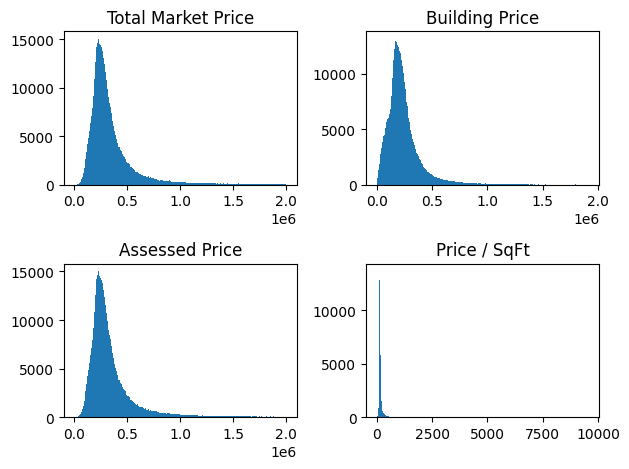

In [10]:
fig, axs = plt.subplots(2, 2)

# Total Market Price
axs[0, 0].hist(y_market, bins="auto")
axs[0, 0].set_title("Total Market Price")

# Assessed values
axs[1, 0].hist(y_assessed, bins="auto")
axs[1, 0].set_title("Assessed Price")

# Building value
axs[0, 1].hist(y_bld_val, bins="auto")
axs[0, 1].set_title("Building Price")

# Price per square foot
axs[1, 1].hist(y_per_sqft, bins="auto")
axs[1, 1].set_title("Price / SqFt")

fig.tight_layout()
plt.show()

In [11]:
# # Removed features: ,, 'solar_panel', 'lat', 'long'
# y_market = df["tot_mkt_val"]
# y_assessed = df["assessed_val"]
# y_bld_val = df["bld_val"]
# y_per_sqft = df["assessed_per_sqft"]

In [12]:
# # IQR
# Q1 = df["assessed_val"].quantile(0.25)
# Q3 = df["assessed_val"].quantile(0.75)
# IQR = Q3 - Q1

# lower_iqr = Q1 - 1.5 * IQR
# upper_iqr = Q3 + 1.5 * IQR
# print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

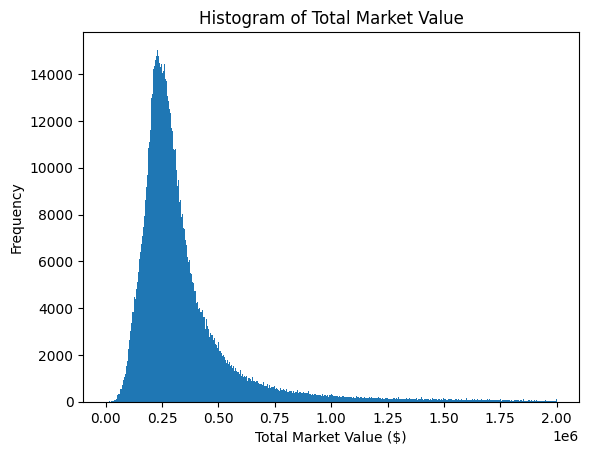

In [13]:
plt.hist(df["tot_mkt_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Total Market Value")
plt.show()

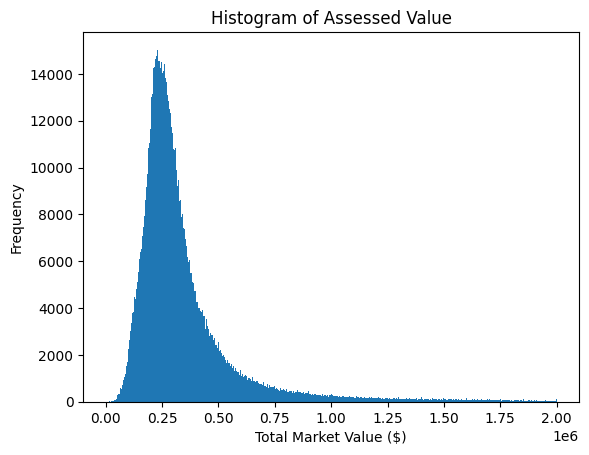

In [14]:
plt.hist(df["assessed_val"], bins="auto")
plt.xlabel("Total Market Value ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Assessed Value")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model.

In [15]:
sample_df = df.sample(n=10000, random_state=42)
show(sample_df)

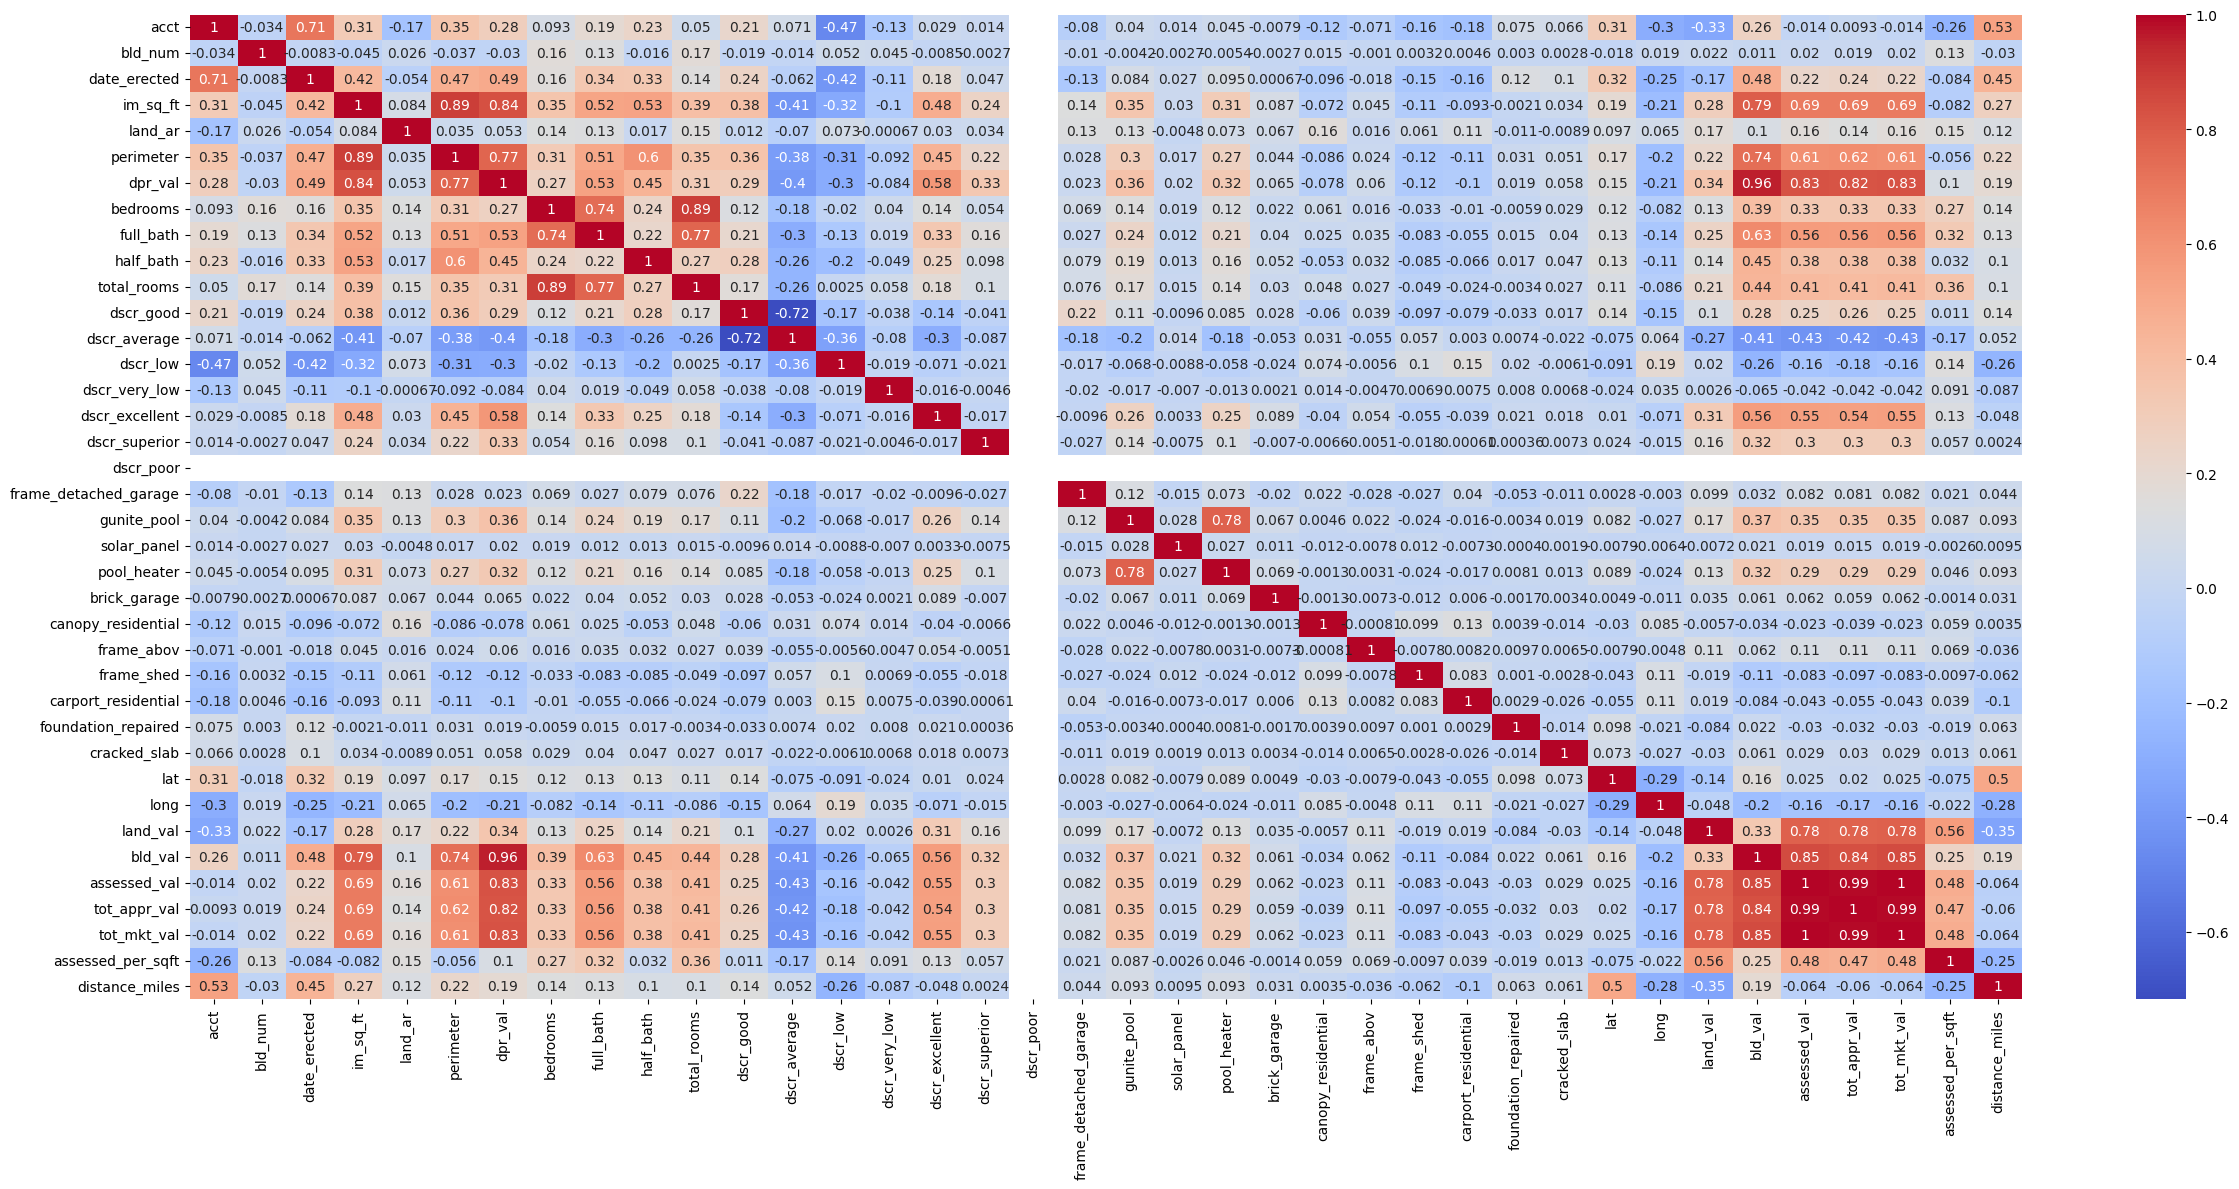

In [16]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

In [17]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "dscr_good",
        "dscr_low",
        "dscr_very_low",
        "dscr_average",
        "dscr_excellent",
        "dscr_superior",
        "dscr_poor",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y_assessed = sample_df["assessed_val"]
print(X.shape)

(10000, 26)


# Train, Test, Split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y_assessed, test_size=0.2, random_state=42
)

In [19]:
etc = ExtraTreesRegressor(random_state=42)

In [20]:
param_grid = {
    "n_estimators": [1600, 1700, 1800, 1900, 2000],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "max_features": [27],
}

In [21]:
etc_cv = GridSearchCV(etc, param_grid, cv=5, n_jobs=-1, scoring="r2")

In [22]:
etc_cv.fit(x_train, y_train)

c:\Users\Blake\OneDrive\Documents\GitHub\HouseProtestValues\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [27],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [1600, 1700, 1800, 1900, 2000]},
             scoring='r2')

In [23]:
etc_cv.best_params_

{'max_features': 27, 'min_samples_leaf': 1, 'n_estimators': 1700}

In [24]:
etc_cv.best_score_

np.float64(0.8067370305653752)

In [25]:
# etc_features = ExtraTreesRegressor(criterion='absolute_error',max_leaf_nodes=3, max_features=50, n_estimators=2000)
# etc_features.fit(x_train, y_train)
# etc_features.feature_importances_

In [26]:
etc_cv_results = pd.DataFrame(etc_cv.cv_results_)
etc_cv_results["param_n_estimators"] = etc_cv_results["param_n_estimators"].astype(
    "category"
)
etc_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       91.726988      1.354618        27.878125        0.984639   
1       99.537429      0.578432        24.694632        0.841503   
2      103.791366      0.887749        22.232793        0.533082   
3      103.745804      2.817182         5.116644        6.676657   
4      107.196224      1.900147         1.720397        0.150440   
5       57.579493      1.593961         0.967580        0.066821   
6       59.460106      1.991769         1.078225        0.123492   
7       62.034107      1.082332         1.029864        0.044999   
8       65.193258      1.843977         1.096981        0.043221   
9       67.583833      1.118690         1.138528        0.063575   
10      44.662644      0.876262         0.748996        0.009752   
11      46.930374      0.766930         0.832673        0.064196   
12      51.035438      0.287745         0.986562        0.158885   
13      53.483693      0.959781         0.941446        0.065554   
14      55.750895      0.766037         1.108423        0.129916   
15      39.816375      0.455721         0.681700        0.026082   
16      42.667264      0.945141         0.790252        0.100539   
17      45.731121      0.891710         0.844978        0.079132   
18      48.500126      0.796488         0.890649        0.084149   
19      50.509118      1.006026         0.844155        0.024370   
20      37.150800      0.437178         0.669886        0.068277   
21      38.831382      0.690504         0.688140        0.049076   
22      41.863099      1.092600         0.750726        0.068280   
23      43.595473      0.755927         0.782814        0.078026   
24      46.021436      0.856048         0.802140        0.045840   
25      34.666652      0.769367         0.652718        0.041356   
26      36.711315      0.644559         0.641121        0.038984   
27      37.638234      0.453922         0.648127        0.041998   
28      37.981531      0.699269         0.570684        0.024260   
29      36.514183      0.977011         0.421262        0.018717   

    param_max_features  param_min_samples_leaf param_n_estimators  \
0                   27                       1               1600   
1                   27                       1               1700   
2                   27                       1               1800   
3                   27                       1               1900   
4                   27                       1               2000   
5                   27                       2               1600   
6                   27                       2               1700   
7                   27                       2               1800   
8                   27                       2               1900   
9                   27                       2               2000   
10                  27                       3               1600   
11                  27                       3               1700   
12                  27                       3               1800   
13                  27                       3               1900   
14                  27                       3               2000   
15                  27                       4               1600   
16                  27                       4               1700   
17                  27                       4               1800   
18                  27                       4               1900   
19                  27                       4               2000   
20                  27                       5               1600   
21                  27                       5               1700   
22                  27                       5               1800   
23                  27                       5               1900   
24                  27                       5               2000   
25                  27                       6               1600   
26                  27          

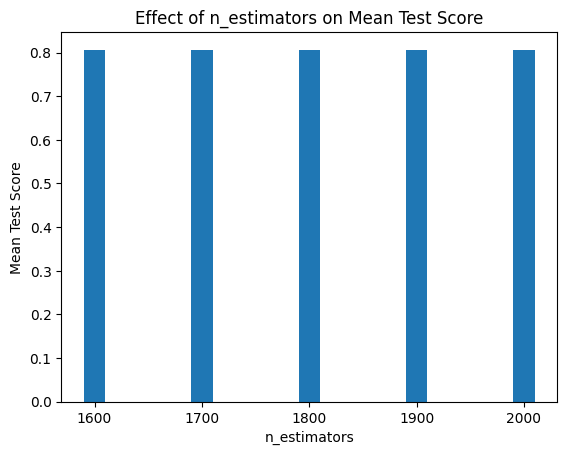

In [27]:
plt.bar(
    etc_cv_results["param_n_estimators"], etc_cv_results["mean_test_score"], width=20
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of n_estimators on Mean Test Score")
plt.show()

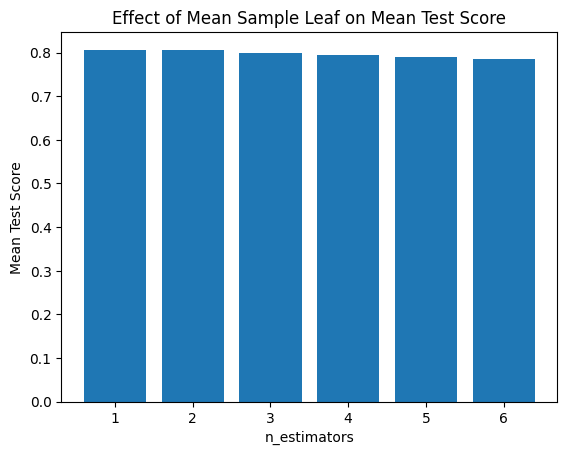

In [28]:
plt.bar(
    etc_cv_results["param_min_samples_leaf"],
    etc_cv_results["mean_test_score"],
    width=0.8,
)
plt.xlabel("n_estimators")
plt.ylabel("Mean Test Score")
plt.title("Effect of Mean Sample Leaf on Mean Test Score")
plt.show()

## Analysis of testing data

In [29]:
etc_pred = etc_cv.predict(x_test)
etc_mae = mean_absolute_error(y_test, etc_pred)
etc_mse = mean_squared_error(y_test, etc_pred)
etc_r2 = r2_score(y_test, etc_pred)
print(f"MAE: {etc_mae}\nMSE: {etc_mse}\nR Squared: {etc_r2}\n")

MAE: 55962.54500705882
MSE: 11334037456.05104
R Squared: 0.8109169568348636



In [30]:
# Save model
import joblib
from datetime import datetime

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d")

joblib.dump(etc_cv, f"Models/etc_{formatted_date}.pkl")

['Models/etc_20241125.pkl']

# Residual Analysis

In [31]:
actual = y_test.to_list()
predicted = etc_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

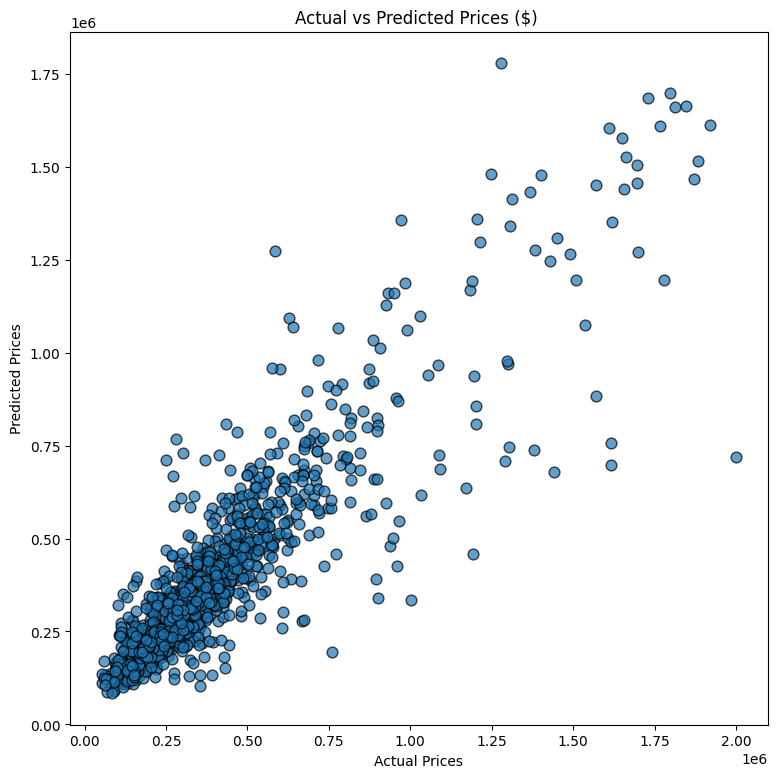

In [32]:
fig, ax = plt.subplots(figsize=(9, 9))

x = etc_residuals["actual"]
y = etc_residuals["predicted"]

# Scatter plot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices ($) ")
plt.show()

## Gradient Boost
The assessed values are not normally distributed, but are skewed right. They will be log transformed and the predicted values will be expectationaled back to assess the residuals.

In [45]:
gbr = GradientBoostingRegressor()

In [46]:
param_grid = {
    "n_estimators": [2000, 3000],
    "learning_rate": [0.005, 0.001],
    "max_depth": [5, 6, 7],
    "min_samples_split": [4, 6, 7],
    "min_samples_leaf": [1],
    "criterion": ["friedman_mse"],
}

In [47]:
gbr_cv = GridSearchCV(gbr, param_grid, cv=5, n_jobs=-1, scoring="r2")

In [48]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

In [49]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 55123.01591679906
MSE: 11052213904.588528
R Squared: 0.8156185519154137



In [50]:
gbr_cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.005,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 3000}

In [51]:
gbr_cv.best_score_

np.float64(0.813014705448953)

In [52]:
joblib.dump(gbr_cv, "Models/gbr.pkl")

# load
# joblib.load('gbr.pkl')

['Models/gbr.pkl']

In [53]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

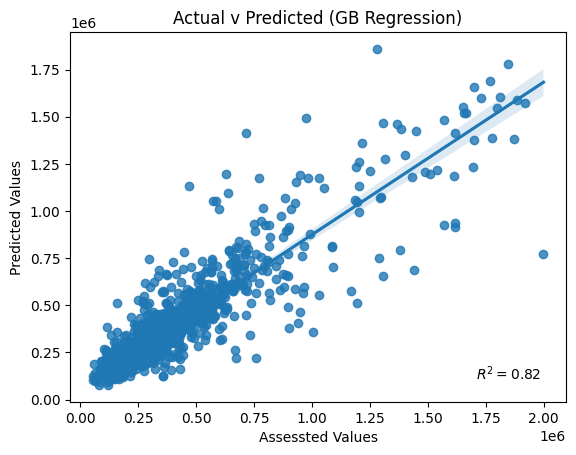

In [59]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel('Assessted Values')
plt.ylabel('Predicted Values')
plt.title('Actual v Predicted (GB Regression)')

plt.text(0.95, 0.05, f"$R^2 = {gbr_r2:.2f}$", 
         horizontalalignment='right', 
         verticalalignment='bottom', 
         transform=plt.gca().transAxes, 
         fontsize=10)
plt.show()

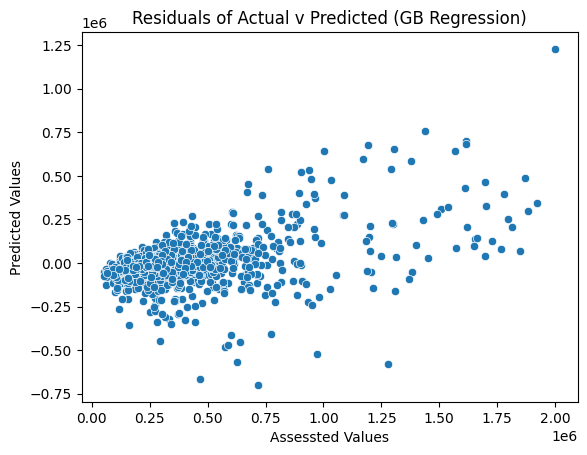

In [62]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel('Assessted Values')
plt.ylabel('Predicted Values')
plt.title('Residuals of Actual v Predicted (GB Regression)')
plt.show()